In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fft import fftshift

import pandas as pd
import glob

dB = lambda x: 10*np.log10(x) # convert mag. to dB

# %load_ext autoreload # auto reload files
# %autoreload 2

## OpenBCI Data Acquisition
Testing data streaming from OpenBCI Ganglion

In [27]:
import time

import brainflow
from brainflow.board_shim import BoardShim, BrainFlowInputParams
from brainflow.data_filter import DataFilter, FilterTypes, AggOperations

board_id = 1 # ganglion definition

def init_openbci():
    BoardShim.enable_dev_board_logger()
    
    params = BrainFlowInputParams()
    params.serial_port = '/dev/cu.usbmodem11'
    
    board = BoardShim(board_id, params)
    return board

def stream_data(board, t_sec):
    board.prepare_session()
    board.start_stream()
    time.sleep(t_sec)
    # data = board.get_current_board_data (256) # get latest 256 packages or less, doesnt remove them from internal buffer
    data = board.get_board_data()  # get all data and remove it from internal buffer
    board.stop_stream()
    board.release_session()
    
    return data
    
board = init_openbci()

In [42]:
sample_time = 12

try:
    print(f"starting data acquisition for {sample_time}s")
    data=stream_data(board, sample_time)
except KeyboardInterrupt:
    print("Received interrupt: stopping session")
    board.stop_stream()
    board.release_session()
print("done")

starting data acquisition for 12s
done


In [43]:
eeg_channels = BoardShim.get_eeg_channels(board_id)
df_raw = pd.DataFrame(np.transpose(data))
df = df_raw[eeg_channels].rename(columns=dict(zip(range(1,5), [f'chan{i}' for i in range(1,5)])))


In [57]:
from eeg_lib.utils import save_data_npz, load_df

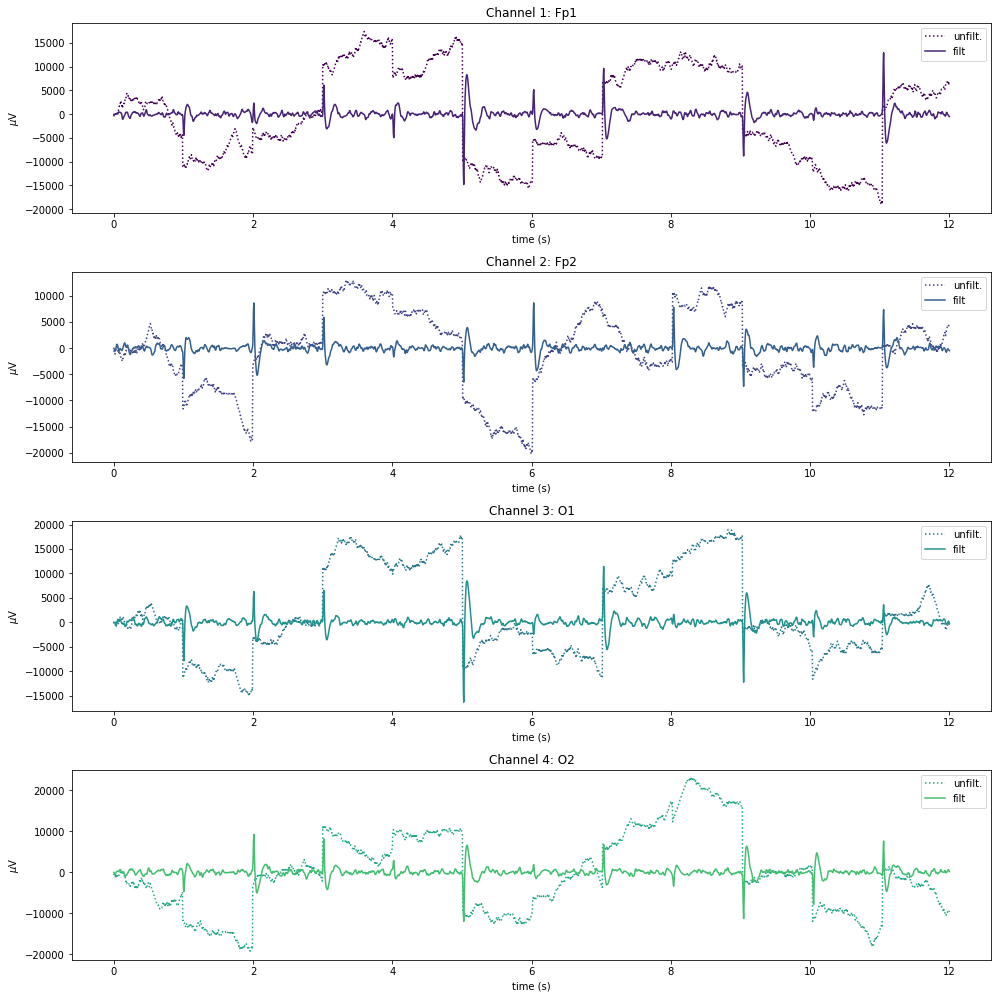

In [44]:
from matplotlib.cm import get_cmap

cm = get_cmap('viridis')

df_filt = df.copy()
filter_ord = 4
centre_freq = 15
bandwidth = 15

for chann in df.columns: # filtering
    # centre freq, bandwidth
    DataFilter.perform_bandpass(df_filt[chann].values, BoardShim.get_sampling_rate(board_id), centre_freq, bandwidth, filter_ord,
                                        FilterTypes.BESSEL.value, 0)

fig, axes = plt.subplots(4,1,figsize=(14,14))
chan_labels = ['Fp1', 'Fp2', 'O1', 'O2']

for i, col in enumerate(df.columns):
    t_ax = np.linspace(0, sample_time, num=len(df))
    axes[i].plot(t_ax, df[col], label='unfilt.', ls=':', c=cm(i*0.2))
    axes[i].plot(t_ax, df_filt[col], label='filt', c=cm(i*0.2+0.1))
    axes[i].set_title(f'Channel {i+1}: {chan_labels[i]}')
    axes[i].set_xlabel('time (s)')
    axes[i].set_ylabel('$\mu$V')
    axes[i].legend()

plt.tight_layout(pad=1.2)

Target SSVEP frequencies (Hz) at: {'F1': 15, 'F2': 25}. Running experiment with SSVEP_f0 = 25Hz
Window start times in seconds: [2.56, 3.84, 5.12, 6.4]


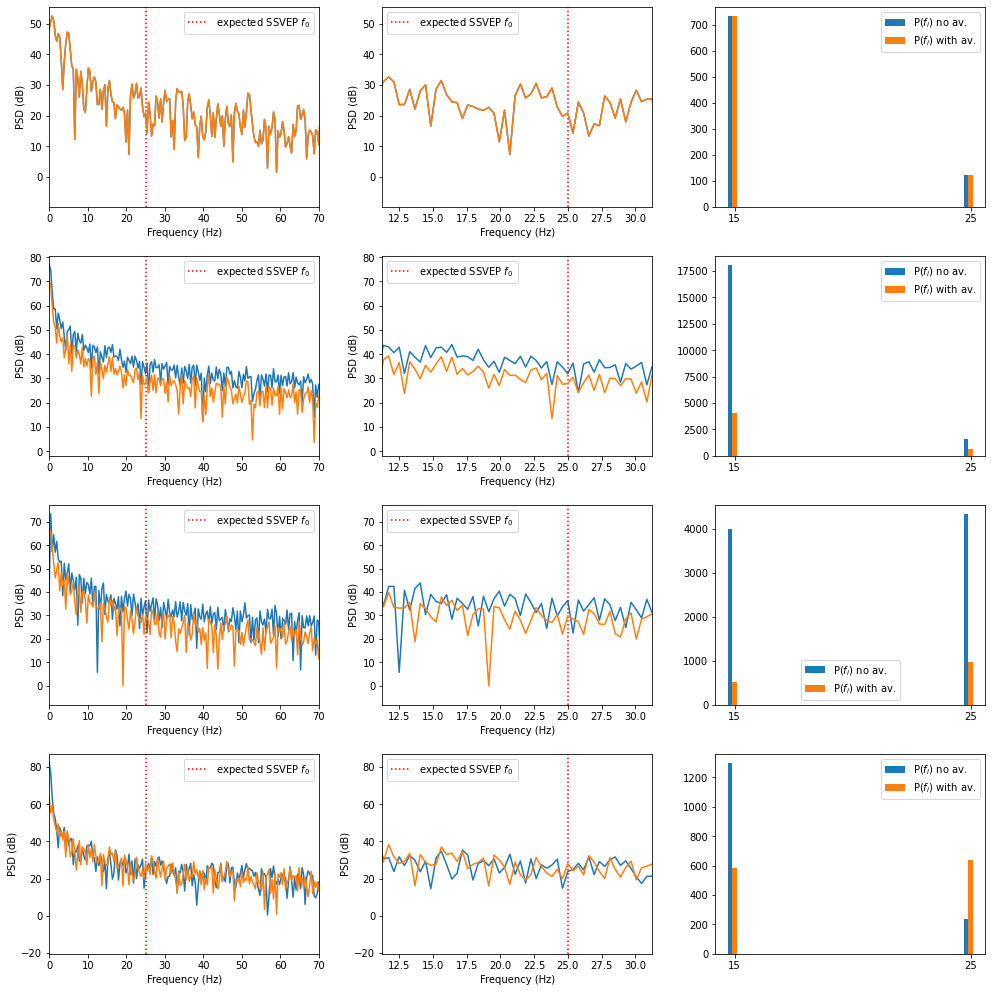

In [45]:
from eeg_lib.freq_analysis import plot_stft_spectra

fs = 200
win_len = 512 # window size in num samples

freq_map = {'F1': 15, 'F2':25}
f_ssvep = np.array(list(freq_map.values()))

ssvep_f0 = 25

target_df = df
x = target_df['chan3']

f, t, Sxx = signal.stft(x, fs, nperseg=win_len, noverlap=win_len//2, window='hann')

f_ssvep = np.array(list(freq_map.values()))
n_plots = 4 # number of windows to consider. Takes first n windows from Sxx matrix
# plot
plot_stft_spectra(Sxx[:, :n_plots], f, ssvep_f0=ssvep_f0, f_ssvep=f_ssvep, figsize=(14,14))

print(f"Target SSVEP frequencies (Hz) at: {freq_map}. Running experiment with SSVEP_f0 = {ssvep_f0}Hz")
win_times = [(1/fs)*win_len*(1+i/2) for i in range(n_plots)]
print(F"Window start times in seconds: {win_times}")

Fundamental SSVEP frequency expected at 15Hz


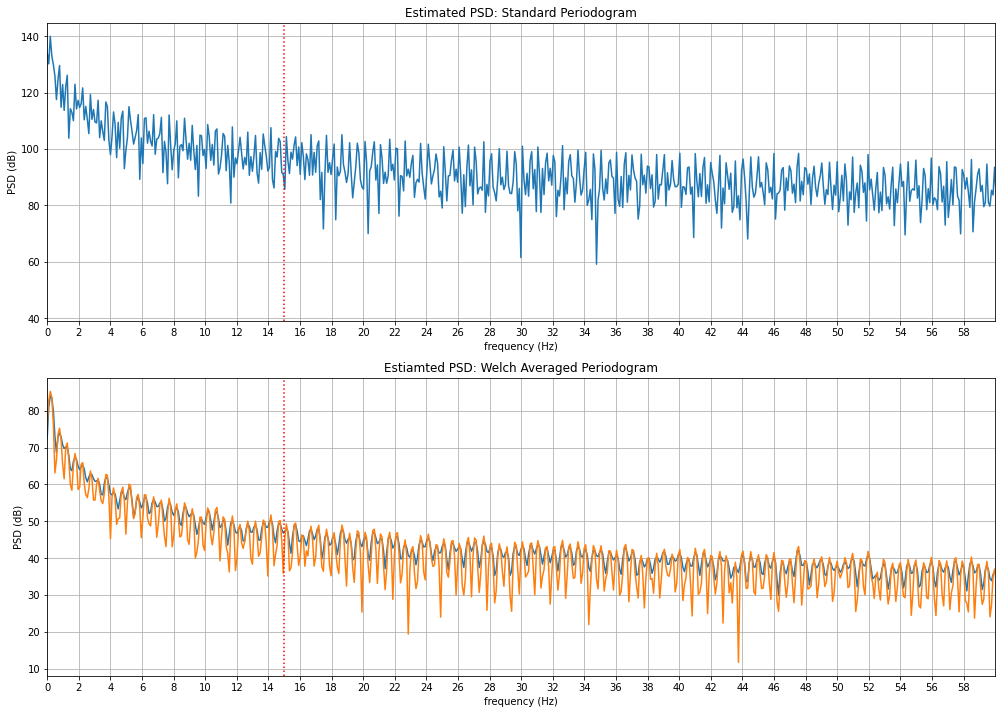

In [46]:
from eeg_lib.freq_analysis import plot_periodogram

plot_periodogram(x, 15, 200, figsize=(14, 10))

## EEG Steady-State Visual Evoked Potential Signals
> Database by Marco Aceves' PhD study

Each subject performed different tests which are provided in .csv format as follows: suppose you have a .csv which name is A001SB1_1 This means the data corresponds to group A (only Group A is provided at present), subject 001, Test SB1 (Five Box Visual Test), and first experiment (_1, there could be a repetition of the experiment which will be _2, _3, etc). The different tests are as follows: SB1 - Five Box Visual Test 1, SB2 - Five Box Visual Test 2, SB3 - Five Box Visual Test 3 (There are three different Five Box tests, these are not repetitions of the same test), SV1 - Visual Image Search, SM1 - Motor Images (Hand Shake Experiment). Since these experiments are visual tests, you may be interested in the electrodes O1 and O2. 

In [100]:
! ls data/

EEG-SSVEP-5Box SSVEP-Acampora beethoven.wav


In [104]:
path = 'data/SSVEP-Acampora/' # use your path
all_files = glob.glob(path + "/*.csv")

dfs = []

def proc(df):
    data_cols = df.columns[-14:]
    df = df.rename(columns=dict(zip(data_cols, 'AF3 F7 F3 FC5 T7 P7 O1 O2 P8 T8 FC6 F4 F8 AF4'.split(' '))))
    df=df.rename(columns=dict(zip(df.columns[:2], ['x(t)', 'interpolated'])))
    return df

for filename in all_files:
    print(f"Loading file {filename}")
    df = pd.read_csv(filename, index_col=None, header=0)
#     dfs.append(proc(df))

# frame = pd.concat(li, axis=0, ignore_index=True)

Loading file data/SSVEP-Acampora/subject2.csv
Loading file data/SSVEP-Acampora/subject3.csv
Loading file data/SSVEP-Acampora/subject1.csv
Loading file data/SSVEP-Acampora/subject4.csv
Loading file data/SSVEP-Acampora/subject5.csv
Loading file data/SSVEP-Acampora/subject7.csv
Loading file data/SSVEP-Acampora/subject6.csv
Loading file data/SSVEP-Acampora/subject11.csv
Loading file data/SSVEP-Acampora/subject10.csv
Loading file data/SSVEP-Acampora/subject8.csv
Loading file data/SSVEP-Acampora/subject9.csv


## SSVEP Study 2 (G. Acampora et al)

### Data acquisition
Data was acquired using a BCI headset built on top of the Olimex EEG-SMT, a two-channel differential input 10-bit analogue-digital converter (ADC) with a sampling frequency of 256 Hz. One channel out of two has been used for developing the proposed dataset.

### Experimental procedure
Subjects were seated on a chair, 70 cm away from a 15.6 inches monitor with a resolution of 1024×768 pixels, and a refresh rate of 60 Hz. The visual stimuli displayed on the monitor consisted of 4 alternating black-white squares with frequencies 8.57 Hz, 10 Hz, 12 Hz and 15 Hz respectively. The electrodes were positioned on the midline sagittal plane at the Frontal Parietal area (Fpz) and the Occipital area (Oz), according to the 10–20 system.

### Data collection
11 volunteers were equipped with the data acquisition headset and asked to focus on the visual stimuli, 16 s each one. Data is stored in eleven .csv files, one for each subject. Each file contains raw EEG data of the four stimuli frequencies.

In [2]:
path = 'data/SSVEP-Acampora/' # use your path
all_files = glob.glob(path + "/*.csv")

dfs = []

for filename in all_files:
    print(f"Loading file {filename}")
    df = pd.read_csv(filename, index_col=None, header=0, sep=';') # note: these files use ; sep
    dfs.append(df/1023)
    
dfs[0]

Loading file data/SSVEP-Acampora/subject2.csv
Loading file data/SSVEP-Acampora/subject3.csv
Loading file data/SSVEP-Acampora/subject1.csv
Loading file data/SSVEP-Acampora/subject4.csv
Loading file data/SSVEP-Acampora/subject5.csv
Loading file data/SSVEP-Acampora/subject7.csv
Loading file data/SSVEP-Acampora/subject6.csv
Loading file data/SSVEP-Acampora/subject11.csv
Loading file data/SSVEP-Acampora/subject10.csv
Loading file data/SSVEP-Acampora/subject8.csv
Loading file data/SSVEP-Acampora/subject9.csv


,F1,F2,F3,F4
0,0.400782,0.308895,0.732160,0.508309
1,0.501466,0.290323,0.722385,0.497556
2,0.499511,0.290323,0.721408,0.479961
3,0.480938,0.266862,0.716520,0.545455
4,0.461388,0.278592,0.694037,0.542522
...,...,...,...,...
4091,0.559140,0.506354,0.518084,0.601173
4092,0.547410,0.481916,0.473118,0.586510
4093,0.536657,0.523949,0.482893,0.644184
4094,0.520039,0.547410,0.527859,0.639296


In [ ]:
plt.pcolormesh(t, f, np.abs(Zxx), vmin=-1, vmax=1, shading='gouraud')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

In [210]:
all_files[2]

'data/SSVEP-Acampora/subject1.csv'

Text(0.5, 1.0, 'Time domain signal')

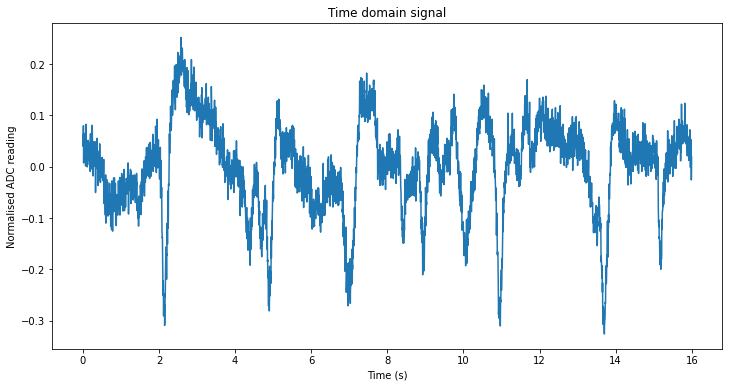

In [3]:
# set signal here
test_freq = 'F4' # which of the freq tests F1-F4
lp_filt = False

freq_map = {'F1': 8.75, 'F2': 10, 'F3': 12, 'F4':15}
x = dfs[2][test_freq].values
ssvep_f0 = freq_map[test_freq]

fs = 256 # sampling freq

x = x - np.mean(x) # mean center data - remove DC component

if lp_filt:
    print("Filtering with butterworth LP filter")
    x = butterworth_lowpass(x, 35, 256, 5)

fig, ax0 = plt.subplots(figsize=(12,6))
ax0.plot(np.arange(len(x))/fs, x)
ax0.set_xlabel('Time (s)')
ax0.set_ylabel('Normalised ADC reading')
ax0.set_title('Time domain signal')
# t = np.arange(len(x))/fs
# ax0.plot(t, np.sin(2*np.pi*ssvep_f0*t))
# ax0.set_xlim(0, 1)

In [21]:
win_len = 512 # window size in num samples
# f,t,Sxx = signal.spectrogram(x, fs=fs, nperseg=win_len, noverlap=win_len//2, mode='magnitude')
f, t, Sxx = signal.stft(x, fs, nperseg=win_len, noverlap=win_len//2, window='hann')

Sxx.shape # (nfft/2+1, n_windows) (real spectrum)
dB = lambda x: 10*np.log10(x)

Target SSVEP frequencies (Hz) at: {'F1': 8.75, 'F2': 10, 'F3': 12, 'F4': 15}. Running experiment with SSVEP_f0 = 15Hz
Window start times in seconds: [2.0, 3.0, 4.0, 5.0, 6.0, 7.0]


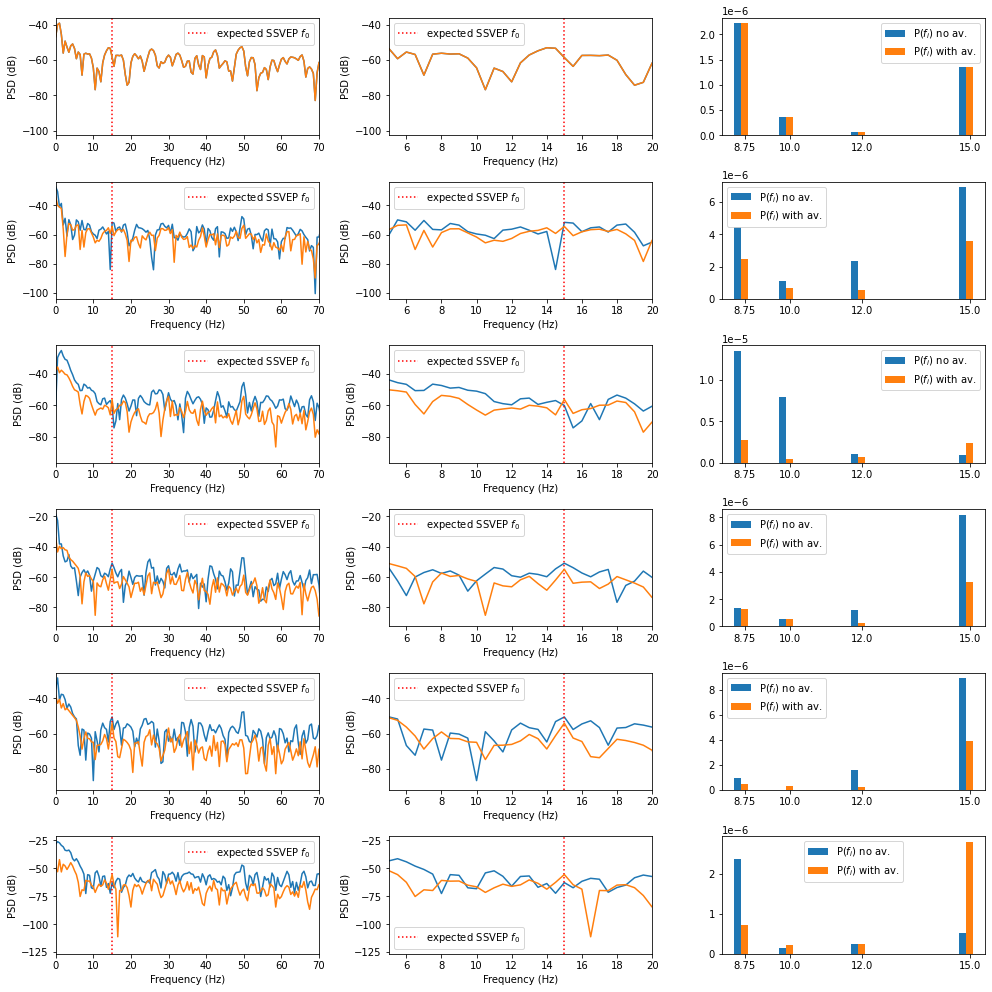

In [22]:
f_ssvep = np.array(list(freq_map.values()))
n_plots = 6 # number of windows to consider. Takes first n windows from Sxx matrix
# plot
plot_stft_spectra(Sxx[:, :n_plots], f, ssvep_f0=ssvep_f0, recursive_av=True, figsize=(14,14))
print(f"Target SSVEP frequencies (Hz) at: {freq_map}. Running experiment with SSVEP_f0 = {ssvep_f0}Hz")
win_times = [(1/fs)*win_len*(1+i/2) for i in range(n_plots)]
print(F"Window start times in seconds: {win_times}")

In [58]:
from eeg_lib.freq_analysis import plot_periodogram

plot_periodogram(x, ssvep_f0, fs)

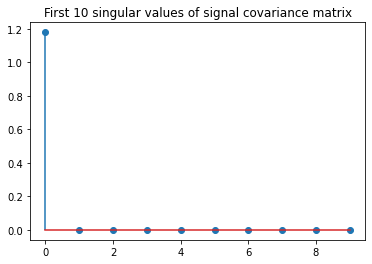

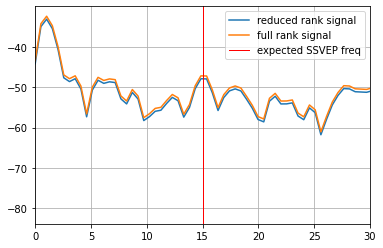

In [13]:
x_vec = x[:512].reshape(-1, 1) # only look at first 512 values = 512 * 1/256 = 2s
if np.mean(x) > 0.001:
    print("Warning: expected zero mean data for calculating covariance matrix")
x_vec.dot(x_vec.T)

U, S, Vh = np.linalg.svd(x_vec.dot(x_vec.T))
plt.stem(S[:10])
plt.title('First 10 singular values of signal covariance matrix')

x_lr = U[:,0].dot(S[0]).reshape(-1, 1).dot(Vh[0, :].reshape(1, -1)).flatten()

f_welch, Pxx_welch = signal.welch(U[:, 0], 256, nperseg=300, nfft=500) # rank-1 signal
f_welch_orig, Pxx_welch_orig = signal.welch(x_vec.flatten(), 256, nperseg=300, nfft=500) # full rank signal

plt.figure()
plt.plot(f_welch, dB(Pxx_welch), label='reduced rank signal')
plt.plot(f_welch_orig, dB(Pxx_welch_orig), label='full rank signal')
plt.xlim(0, 30)
# plt.axvline(8.75, lw='1.2', c='r')
plt.axvline(15, c='r', lw=1, label='expected SSVEP freq')
plt.grid()
plt.legend()

In [ ]:
from scipy.signal import butter,filtfilt
# Filter requirements.

def butterworth_lowpass(x, fc, fs, order):
    nyq = 0.5 * fs  # Nyquist Frequency
    normal_cutoff = fc / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, x)
    return y

In [ ]:
import numpy.fft as fft


def stft(x, Nwin, Nfft=None):
    """
    Short-time Fourier transform: convert a 1D vector to a 2D array
    The short-time Fourier transform (STFT) breaks a long vector into disjoint
    chunks (no overlap) and runs an FFT (Fast Fourier Transform) on each chunk.
    The resulting 2D array can 
    Parameters
    ----------
    x : array_like
        Input signal (expected to be real)
    Nwin : int
        Length of each window (chunk of the signal). Should be ≪ `len(x)`.
    Nfft : int, optional
        Zero-pad each chunk to this length before FFT. Should be ≥ `Nwin`,
        (usually with small prime factors, for fastest FFT). Default: `Nwin`.
    Returns
    -------
    out : complex ndarray
        `len(x) // Nwin` by `Nfft` complex array representing the STFT of `x`.
    
    See also
    --------
    istft : inverse function (convert a STFT array back to a data vector)
    stftbins : time and frequency bins corresponding to `out`
    """
    Nfft = Nfft or Nwin
    Nwindows = x.size // Nwin
    # reshape into array `Nwin` wide, and as tall as possible. This is
    # optimized for C-order (row-major) layouts.
    arr = np.reshape(x[:Nwindows * Nwin], (-1, Nwin))
    stft = fft.rfft(arr, Nfft)
    return stft


def stftbins(x, Nwin, Nfft=None, d=1.0):
    """
    Time and frequency bins corresponding to short-time Fourier transform.
    Call this with the same arguments as `stft`, plus one extra argument: `d`
    sample spacing, to get the time and frequency axes that the output of
    `stft` correspond to.
    Parameters
    ----------
    x : array_like
        same as `stft`
    Nwin : int
        same as `stft`
    Nfft : int, optional
        same as `stft`
    d : float, optional
        Sample spacing of `x` (or 1 / sample frequency), units of seconds.
        Default: 1.0.
    Returns
    -------
    t : ndarray
        Array of length `len(x) // Nwin`, in units of seconds, corresponding to
        the first dimension (height) of the output of `stft`.
    f : ndarray
        Array of length `Nfft`, in units of Hertz, corresponding to the second
        dimension (width) of the output of `stft`.
    """
    Nfft = Nfft or Nwin
    Nwindows = x.size // Nwin
    t = np.arange(Nwindows) * (Nwin * d)
    f = fft.rfftfreq(Nfft, d)
    return t, f